In [1]:
import os
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms

import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import itertools

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

C:\Users\Max\miniconda3\envs\Comp472\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# ===================== MODEL ===================== #

In [3]:
num_epochs = 4
test_batch_size = 120

img_height = 140
img_width = 140

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=90, kernel_size=3, padding=1),
        nn.BatchNorm2d(90),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(26010, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    # conv layers
    x = self.conv_layer(x)

    # flatten
    x = x.view(x.size(0), -1)

    # fc layer
    x = self.fc_layer(x)

    return x

In [4]:
# ===================== IMPORT DATASET / MODEL ===================== #

In [5]:
imagePath = "Dataset"
modelDir = "TrainedModel_V3"
outputPath = "train_test_sets"
testDir = "BiasSubclasses/Gender/Female"

classes = ["Cloth", "N95", "None", "Surgical"]

In [6]:
#splitfolders.ratio(imagePath, output=outputPath, seed=0, ratio=(.8, 0.1,.1))

In [7]:
model = CNN()
model.load_state_dict(torch.load("TrainedModel_V2"), strict=False)

<All keys matched successfully>

In [8]:
transform = transforms.Compose([transforms.Resize((img_width, img_height)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_ds = datasets.ImageFolder(testDir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test_batch_size, shuffle=False)

In [9]:
# ===================== EVALUATION ===================== #

In [10]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        for l, p in zip(labels.numpy(), predicted.numpy()):
            y_true.append(classes[l])
            y_pred.append(classes[p])

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_plot_labels = classes
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=cm_plot_labels)

Confusion matrix, without normalization
[[ 9  1  0  0]
 [ 1  9  0  0]
 [ 0  0 10  0]
 [ 0  4  0  6]]


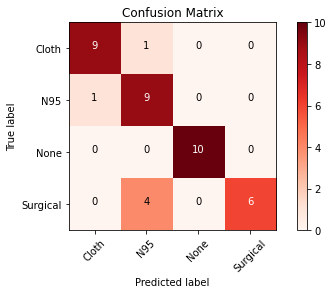

In [13]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Reds)

In [14]:
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print(f"precision: {precision: .2f}")
print(f"recall: {recall: .2f}")
print(f"f1: {f1: .2f}")
print(f"accuracy: {accuracy: .2f}")

precision:  0.89
recall:  0.85
f1:  0.85
accuracy:  0.85
